# 計算機程式期末報告-貓狗分辨

## 組員名單:
統計二 107304006 呂嘉恩

統計二 107304009 吳松霖

統計二 107304033 蔡睿承

財政二 107205018 黃國洋

## 專案分工:

統計二 107304006 呂嘉恩：資料搜尋，建模及找出較好的數字

統計二 107304009 吳松霖：資料集的分類整理、建模，打註解

統計二 107304033 蔡睿承：資料集分類整理、打亂，Debug，打註解

財政二 107205018 黃國洋：資料搜尋，建模及找出最好的優化器

由於是大家聚在一起做的，全員都有參與到，所以其實很難細分

## 問題發想:

我們好奇同為長身體四隻腳兩耳朵，體態相近的貓跟狗，僅有些許五官面孔的不同，

AI是否能夠準確的辨認出來。

因此採用外型相同，五官輪廓較明顯不同的貓和狗，作為訓練資料，應該較不易有問題。

## 流程介紹:

這次總共呈現了兩個模型，分別是模型一及模型二。

模型一為我們較早期做出的模型，模型一共用了三種不同的最佳化辦法，取了準確率最高的Adam作為優化器的選擇。

但我們後來在進行優化調整時，發現由於經驗不足，而沒有將資料集打亂再進行訓練。

而我們用的分類方式又沒辦法很好的將其打亂，因此模型二我們採用了不同的資料分類方式。而準確率有些許提升。

#### 簡易流程如下：

#### 模型一

1.載入模組

2.匯入資料集並整理

3.打造CNN模型

4.訓練資料

5.預測

#### 模型二

1.載入模組

2.匯入資料集並將其打亂

3.將打亂資料集做整理

4.打造CNN模型

5.訓練資料

6.預測

## 資料來源:

Kaggle:'https://www.kaggle.com/c/dogs-vs-cats'

# 模型一

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
import os #處理文件用
import cv2 #處理影像

In [2]:
print(os.listdir()) #確認我們目錄下的資料夾名稱

['.ipynb_checkpoints', '2.ipynb', 'Cats_vs_Dogs-master', 'CNN_Dog_vs_Cat.ipynb', 'kagglecatsanddogs_3367a', 'submission.csv', 'test1', 'train', 'train1', 'Untitled.ipynb', 'Untitled1.ipynb', 'Untitled3.ipynb', 'Untitled4.ipynb', 'Untitled5.ipynb']


### 導入Kaggle上下載的資料集，並整理資料

In [4]:
x_train=[] #創建空的list
y_train=[]
path=os.path.join('train1') #在這裡令一個路徑，這樣要換資料夾時才不用去程式內部一個一個改

for i in os.listdir(path):
    name=i.split(".")[0]   #找出圖片以'.'為切割的名字開頭
#     print(name)
    if name=="dog":        #如果圖片名稱為dog開頭則 label=1，反之若是cat則 label=0
        label=int(1)
    else:
        label=int(0)
#     print(label)
    img=cv2.imread(os.path.join(path,i),cv2.IMREAD_GRAYSCALE)     #我們使用灰階。試過彩色的，但這樣不知道為什麼圖片做出來會失真
#     print(cv2.imread(os.path.join(path,i)))
    nimg=cv2.resize(img,dsize=(150,150))    #將每個圖片大小調整成150X150
    x_train.append(nimg) #將調整好的圖片加入list
    y_train.append(label) #加入它們的label編號


### 資料處理

In [6]:
x_train=np.array(x_train).reshape(-1,150,150,1) #重塑資料，用-1讓他自己去判斷個數
x_train=x_train/255 #標準化

In [7]:
x_train.shape #25000筆,150x150的照片,灰階圖片所以1個Channel

(25000, 150, 150, 1)

In [8]:
x_train[5].shape

(150, 150, 1)

In [9]:
y_train= np.array(y_train) #將資料轉成array
y_train[5] 

0

### 打造我們的CNN

In [11]:
#命名一個新模型
model = Sequential() 

#第一層Filter用3x3的矩陣，數量為32，池化窗口為2x2，激活函數為relu
model.add(Conv2D(32,(3,3),input_shape=(150,150,1),padding='same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

#第二層Filter用3x3的矩陣，數量為64，池化窗口為2x2，激活函數為relu
model.add(Conv2D(64,(3,3),padding='same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten()) #拉平

#第一層為64個神經元，激活函數為relu
model.add(Dense(64, activation='relu'))

#第二層為1個神經元，因為資料為二分類所以最後一層激活函數使用sigmoid
model.add(Dense(1, activation='sigmoid'))


### 檢視模型

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5607488   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

### 在這裡我們optimizer總共試了3種，Adam為準確率最高的0.82

### SGD(learning rate使用0.01) 準確率為0.6多

### AdaGrad 準確率則為0.72上下

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### 訓練資料，每100筆資料修正一次，跑3次

In [14]:
model.fit(x_train,y_train, epochs=3, batch_size=100)

Epoch 1/3
186/250 [=====================>........] - ETA: 0s - loss: 0.6997 - accuracy: 0.49 - ETA: 2:22 - loss: 1.3316 - accuracy: 0.52 - ETA: 3:00 - loss: 1.1123 - accuracy: 0.53 - ETA: 3:20 - loss: 1.1116 - accuracy: 0.49 - ETA: 3:31 - loss: 1.0505 - accuracy: 0.50 - ETA: 3:39 - loss: 0.9959 - accuracy: 0.49 - ETA: 3:43 - loss: 0.9520 - accuracy: 0.50 - ETA: 3:48 - loss: 0.9199 - accuracy: 0.50 - ETA: 3:52 - loss: 0.8948 - accuracy: 0.49 - ETA: 3:54 - loss: 0.8749 - accuracy: 0.48 - ETA: 3:56 - loss: 0.8589 - accuracy: 0.48 - ETA: 3:57 - loss: 0.8453 - accuracy: 0.48 - ETA: 3:56 - loss: 0.8334 - accuracy: 0.48 - ETA: 3:56 - loss: 0.8235 - accuracy: 0.48 - ETA: 3:55 - loss: 0.8149 - accuracy: 0.48 - ETA: 3:55 - loss: 0.8073 - accuracy: 0.48 - ETA: 3:54 - loss: 0.8005 - accuracy: 0.48 - ETA: 3:53 - loss: 0.7945 - accuracy: 0.49 - ETA: 3:53 - loss: 0.7890 - accuracy: 0.49 - ETA: 3:52 - loss: 0.7842 - accuracy: 0.50 - ETA: 3:52 - loss: 0.7799 - accuracy: 0.50 - ETA: 3:51 - loss: 0.7758 

186/250 [=====================>........] - ETA: 0s - loss: 0.5023 - accuracy: 0.77 - ETA: 2:00 - loss: 0.5218 - accuracy: 0.72 - ETA: 2:42 - loss: 0.5138 - accuracy: 0.73 - ETA: 3:08 - loss: 0.5316 - accuracy: 0.72 - ETA: 3:21 - loss: 0.5274 - accuracy: 0.72 - ETA: 3:28 - loss: 0.5213 - accuracy: 0.73 - ETA: 3:33 - loss: 0.5208 - accuracy: 0.73 - ETA: 3:36 - loss: 0.5155 - accuracy: 0.74 - ETA: 3:37 - loss: 0.5114 - accuracy: 0.75 - ETA: 3:39 - loss: 0.5115 - accuracy: 0.74 - ETA: 3:40 - loss: 0.5120 - accuracy: 0.74 - ETA: 3:41 - loss: 0.5155 - accuracy: 0.74 - ETA: 3:41 - loss: 0.5092 - accuracy: 0.75 - ETA: 3:41 - loss: 0.5095 - accuracy: 0.75 - ETA: 3:41 - loss: 0.5140 - accuracy: 0.75 - ETA: 3:41 - loss: 0.5196 - accuracy: 0.74 - ETA: 3:42 - loss: 0.5158 - accuracy: 0.75 - ETA: 3:43 - loss: 0.5171 - accuracy: 0.75 - ETA: 3:43 - loss: 0.5162 - accuracy: 0.74 - ETA: 3:44 - loss: 0.5149 - accuracy: 0.74 - ETA: 3:44 - loss: 0.5154 - accuracy: 0.74 - ETA: 3:44 - loss: 0.5146 - accuracy

250/250 [==============================] - ETA: 1:16 - loss: 0.5086 - accuracy: 0.75 - ETA: 1:15 - loss: 0.5086 - accuracy: 0.75 - ETA: 1:14 - loss: 0.5086 - accuracy: 0.75 - ETA: 1:13 - loss: 0.5093 - accuracy: 0.74 - ETA: 1:12 - loss: 0.5091 - accuracy: 0.74 - ETA: 1:11 - loss: 0.5090 - accuracy: 0.74 - ETA: 1:10 - loss: 0.5091 - accuracy: 0.74 - ETA: 1:09 - loss: 0.5091 - accuracy: 0.74 - ETA: 1:08 - loss: 0.5088 - accuracy: 0.75 - ETA: 1:07 - loss: 0.5085 - accuracy: 0.75 - ETA: 1:06 - loss: 0.5080 - accuracy: 0.75 - ETA: 1:05 - loss: 0.5078 - accuracy: 0.75 - ETA: 1:04 - loss: 0.5077 - accuracy: 0.75 - ETA: 1:02 - loss: 0.5080 - accuracy: 0.75 - ETA: 1:01 - loss: 0.5079 - accuracy: 0.75 - ETA: 1:00 - loss: 0.5080 - accuracy: 0.75 - ETA: 59s - loss: 0.5079 - accuracy: 0.7509 - ETA: 58s - loss: 0.5076 - accuracy: 0.750 - ETA: 57s - loss: 0.5078 - accuracy: 0.750 - ETA: 56s - loss: 0.5078 - accuracy: 0.750 - ETA: 55s - loss: 0.5075 - accuracy: 0.750 - ETA: 53s - loss: 0.5074 - accura

### 準確率希望有8成，因此在多訓練1次

In [15]:
model.fit(x_train,y_train, epochs=1, batch_size=100)

186/250 [=====================>........] - ETA: 0s - loss: 0.4899 - accuracy: 0.80 - ETA: 2:36 - loss: 0.4769 - accuracy: 0.77 - ETA: 3:14 - loss: 0.4550 - accuracy: 0.78 - ETA: 3:31 - loss: 0.4313 - accuracy: 0.81 - ETA: 3:41 - loss: 0.4265 - accuracy: 0.80 - ETA: 3:48 - loss: 0.4128 - accuracy: 0.81 - ETA: 3:50 - loss: 0.4028 - accuracy: 0.81 - ETA: 3:54 - loss: 0.3982 - accuracy: 0.82 - ETA: 3:55 - loss: 0.3936 - accuracy: 0.82 - ETA: 3:57 - loss: 0.3884 - accuracy: 0.82 - ETA: 3:58 - loss: 0.3955 - accuracy: 0.82 - ETA: 3:59 - loss: 0.3942 - accuracy: 0.82 - ETA: 3:58 - loss: 0.3973 - accuracy: 0.82 - ETA: 3:58 - loss: 0.3971 - accuracy: 0.82 - ETA: 3:57 - loss: 0.3898 - accuracy: 0.82 - ETA: 3:57 - loss: 0.3905 - accuracy: 0.82 - ETA: 3:57 - loss: 0.3886 - accuracy: 0.82 - ETA: 3:56 - loss: 0.3904 - accuracy: 0.82 - ETA: 3:55 - loss: 0.3890 - accuracy: 0.82 - ETA: 3:55 - loss: 0.3904 - accuracy: 0.82 - ETA: 3:55 - loss: 0.3869 - accuracy: 0.82 - ETA: 3:55 - loss: 0.3825 - accuracy

250/250 [==============================] - ETA: 1:04 - loss: 0.3910 - accuracy: 0.82 - ETA: 1:03 - loss: 0.3908 - accuracy: 0.82 - ETA: 1:02 - loss: 0.3905 - accuracy: 0.82 - ETA: 1:01 - loss: 0.3906 - accuracy: 0.82 - ETA: 1:00 - loss: 0.3908 - accuracy: 0.82 - ETA: 59s - loss: 0.3909 - accuracy: 0.8260 - ETA: 58s - loss: 0.3907 - accuracy: 0.826 - ETA: 57s - loss: 0.3909 - accuracy: 0.825 - ETA: 56s - loss: 0.3907 - accuracy: 0.825 - ETA: 55s - loss: 0.3905 - accuracy: 0.826 - ETA: 54s - loss: 0.3907 - accuracy: 0.825 - ETA: 52s - loss: 0.3905 - accuracy: 0.826 - ETA: 51s - loss: 0.3902 - accuracy: 0.826 - ETA: 50s - loss: 0.3904 - accuracy: 0.826 - ETA: 49s - loss: 0.3905 - accuracy: 0.826 - ETA: 48s - loss: 0.3900 - accuracy: 0.826 - ETA: 47s - loss: 0.3899 - accuracy: 0.826 - ETA: 46s - loss: 0.3904 - accuracy: 0.826 - ETA: 45s - loss: 0.3910 - accuracy: 0.826 - ETA: 44s - loss: 0.3915 - accuracy: 0.825 - ETA: 43s - loss: 0.3912 - accuracy: 0.826 - ETA: 42s - loss: 0.3911 - accura

### 導入測試資料並整理

In [16]:
x_test=[] #創建空list
path=os.path.join("test1") #設定資料夾

for i in os.listdir(path):
    img=cv2.imread(os.path.join(path,i),cv2.IMREAD_GRAYSCALE) #使用灰階，並將檔案轉為array
    nimg=cv2.resize(img,dsize=(150,150)) #修改大小為150x150
    x_test.append(nimg)


In [17]:
x_test=np.array(x_test).reshape(-1,150,150,1) #重塑維度
x_test=x_test/255 #標準化

### 預測

In [18]:
result = model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [21]:
def my_predict(n):
    if result[n]==int(0):   #label=0 則為貓
        a='貓'
    else:
        a='狗'              #label=1 則為狗
    print('我可愛的 CNN 預測是', a)
    X = x_test[n].reshape(150,150)
    
    plt.imshow(X)

我可愛的 CNN 預測是 貓


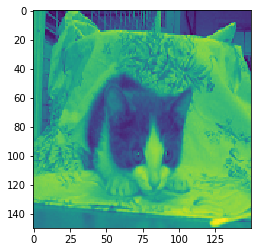

In [28]:
my_predict(87)

### BUTBUTBUT (心路歷程可跳過)

#### 身為Python小白的我們四個發現一件事情

#### 我們做的模型，少做一件事情，是在做資料學習時很重要的事

#### 也就是打亂資料集

#### 上網爬了很多文章發現如果沒有打亂資料集，有可能會影響模型的泛化能力

#### 進而導致我們耳熟的overfitting狀況

#### 於是乎在經過漫長的爬文時間後，終於看懂了怎麼打亂資料集

#### 於是，再參考許多資料後發現了這篇，有一步步的教學，雖然下面幾乎看不懂，


#### 但是這篇打亂的地方還是能勉強看懂的

#### "https://codertw.com/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80/491275/#outline__1_2"

#### 搭配著print學習法，不斷把資料print出來後我們終於知道要怎麼打亂資料集了

# 模型二

### 我們首先一樣導入train的資料，但因為要打亂


### 我們模型一命名label的方式要做修改

### 不然打亂的label沒辦法跟著它的圖片一致

### 一樣將檔名為 cat 開頭為 label=0，dog 則 label=1

In [71]:
path='train1' #設定路徑
cats =  [] #建立空list
label_cats = []
dogs = []
label_dogs = []
for file in os.listdir(path):
    name = file.split(sep='.') #以.為分割
    if name[0]=='cat':
        cats.append(file) #將檔名加進list
        label_cats.append(0) #貓的label=0
    else:
        dogs.append(file)
        label_dogs.append(1) #狗的label=1



### 檢視資料我們發現前面圖片均為貓，後面圖片均為狗

In [72]:
print(cats,label_cats)
print(dogs,label_dogs)

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg', 'cat.10002.jpg', 'cat.10003.jpg', 'cat.10004.jpg', 'cat.10005.jpg', 'cat.10006.jpg', 'cat.10007.jpg', 'cat.10008.jpg', 'cat.10009.jpg', 'cat.1001.jpg', 'cat.10010.jpg', 'cat.10011.jpg', 'cat.10012.jpg', 'cat.10013.jpg', 'cat.10014.jpg', 'cat.10015.jpg', 'cat.10016.jpg', 'cat.10017.jpg', 'cat.10018.jpg', 'cat.10019.jpg', 'cat.1002.jpg', 'cat.10020.jpg', 'cat.10021.jpg', 'cat.10022.jpg', 'cat.10023.jpg', 'cat.10024.jpg', 'cat.10025.jpg', 'cat.10026.jpg', 'cat.10027.jpg', 'cat.10028.jpg', 'cat.10029.jpg', 'cat.1003.jpg', 'cat.10030.jpg', 'cat.10031.jpg', 'cat.10032.jpg', 'cat.10033.jpg', 'cat.10034.jpg', 'cat.10035.jpg', 'cat.10036.jpg', 'cat.10037.jpg', 'cat.10038.jpg', 'cat.10039.jpg', 'cat.1004.jpg', 'cat.10040.jpg', 'cat.10041.jpg', 'cat.10042.jpg', 'cat.10043.jpg', 'cat.10044.jpg', 'cat.10045.jpg', 'cat.10046.jpg', 'cat.10047.jpg', 'cat.10048.jpg', 'cat.10049.jpg', 'cat.1005.jpg'

### 為了要解決這個問題我們決定將資料集順序打亂

### 首先我們將前面貓與狗的list結合

In [73]:
image_list = np.hstack((cats, dogs))#將貓狗圖片堆積起來
label_list = np.hstack((label_cats,label_dogs))#label也堆積起來

In [74]:
print(image_list) #檢視
print(label_list)

['cat.0.jpg' 'cat.1.jpg' 'cat.10.jpg' ... 'dog.9997.jpg' 'dog.9998.jpg'
 'dog.9999.jpg']
[0 0 0 ... 1 1 1]


### 結合後轉為array，並將其轉置

In [75]:
temp = np.array([image_list,label_list])

In [76]:
print(temp)#檢視

[['cat.0.jpg' 'cat.1.jpg' 'cat.10.jpg' ... 'dog.9997.jpg' 'dog.9998.jpg'
  'dog.9999.jpg']
 ['0' '0' '0' ... '1' '1' '1']]


In [77]:
temp = temp.transpose()#轉置矩陣

In [78]:
print(temp)#檢視轉置後結果

[['cat.0.jpg' '0']
 ['cat.1.jpg' '0']
 ['cat.10.jpg' '0']
 ...
 ['dog.9997.jpg' '1']
 ['dog.9998.jpg' '1']
 ['dog.9999.jpg' '1']]


### 接下來使用shuffle打亂順序

In [79]:
np.random.shuffle(temp)#打亂矩陣順序

In [80]:
print(temp)#檢視

[['cat.12204.jpg' '0']
 ['cat.3378.jpg' '0']
 ['cat.9244.jpg' '0']
 ...
 ['dog.4270.jpg' '1']
 ['dog.5472.jpg' '1']
 ['dog.2214.jpg' '1']]


### 再將打亂後的資料提取出

In [81]:
image_list = list(temp[:,0])#提取矩陣第一行

In [82]:
print(image_list)#檢視

['cat.12204.jpg', 'cat.3378.jpg', 'cat.9244.jpg', 'cat.2592.jpg', 'cat.9639.jpg', 'dog.8424.jpg', 'cat.6861.jpg', 'dog.4156.jpg', 'dog.396.jpg', 'dog.50.jpg', 'cat.2127.jpg', 'dog.7787.jpg', 'dog.2649.jpg', 'cat.11757.jpg', 'dog.11136.jpg', 'dog.11822.jpg', 'cat.2662.jpg', 'dog.1994.jpg', 'dog.6472.jpg', 'dog.8863.jpg', 'dog.11348.jpg', 'cat.9781.jpg', 'dog.12116.jpg', 'cat.10104.jpg', 'cat.4345.jpg', 'cat.4412.jpg', 'cat.7995.jpg', 'cat.4475.jpg', 'cat.9806.jpg', 'dog.10493.jpg', 'dog.8899.jpg', 'dog.2279.jpg', 'dog.12039.jpg', 'dog.7381.jpg', 'cat.11731.jpg', 'cat.4091.jpg', 'cat.2457.jpg', 'cat.5433.jpg', 'cat.548.jpg', 'dog.1967.jpg', 'dog.7001.jpg', 'dog.9310.jpg', 'cat.5454.jpg', 'dog.72.jpg', 'dog.1592.jpg', 'dog.8042.jpg', 'dog.1263.jpg', 'cat.4883.jpg', 'cat.3783.jpg', 'cat.12333.jpg', 'cat.2129.jpg', 'dog.824.jpg', 'cat.2233.jpg', 'dog.9939.jpg', 'cat.7176.jpg', 'cat.12149.jpg', 'dog.6423.jpg', 'cat.2685.jpg', 'cat.3141.jpg', 'dog.7453.jpg', 'cat.7584.jpg', 'dog.11193.jpg', '

In [83]:
label_list = list(temp[:,1])#提取矩陣第二行

In [84]:
print(label_list)#檢視

['0', '0', '0', '0', '0', '1', '0', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '1', '1', '0', '1', '0', '1', '1', '1', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '1', '0', '1', '1', '0', '1', '0', '1', '1', '1', '0', '1', '1', '0', '1', '0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '1', '1', '1', '1', '1', '0',

In [85]:
label_list = [int(i) for i in label_list]#將文字轉成數字

In [86]:
print(label_list)#檢視

[0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 

### 成功提取資料後，我們看到資料已經被打亂

### 因此利用opencv修改圖片大小為150x150，並將其轉成array

In [87]:
x_train=[] #建立空的list
y_train=label_list 
path=os.path.join('train1') #設定路徑
for j in image_list:
    img=cv2.imread(os.path.join(path,j),cv2.IMREAD_GRAYSCALE) #一樣使用灰階
    nimg=cv2.resize(img,dsize=(150,150)) #修改大小
    x_train.append(nimg) #加入array型態的圖片資料

In [90]:
# print(x_train)#檢視

In [92]:
# print(y_train)#檢視

### 重塑資料將其轉成我們要的

In [93]:
x_train=np.array(x_train).reshape(-1,150,150,1) #轉換資料
x_train=x_train/255 #標準化

In [94]:
x_train.shape #25000筆,150x150的照片,1個Channel灰階

(25000, 150, 150, 1)

In [95]:
x_train[5].shape #確認資料格式

(150, 150, 1)

In [100]:
print(x_train)#檢視

[[[[0.60784314]
   [0.6       ]
   [0.59215686]
   ...
   [0.48627451]
   [0.53333333]
   [0.5254902 ]]

  [[0.61960784]
   [0.61176471]
   [0.61568627]
   ...
   [0.45490196]
   [0.52941176]
   [0.54901961]]

  [[0.6       ]
   [0.6       ]
   [0.62352941]
   ...
   [0.4745098 ]
   [0.49019608]
   [0.55686275]]

  ...

  [[0.11764706]
   [0.10980392]
   [0.15686275]
   ...
   [0.09019608]
   [0.12941176]
   [0.12941176]]

  [[0.12156863]
   [0.13333333]
   [0.17254902]
   ...
   [0.09803922]
   [0.1254902 ]
   [0.12941176]]

  [[0.11764706]
   [0.12941176]
   [0.12941176]
   ...
   [0.07058824]
   [0.09411765]
   [0.10980392]]]


 [[[0.30980392]
   [0.29803922]
   [0.30196078]
   ...
   [0.62745098]
   [0.64705882]
   [0.63921569]]

  [[0.29803922]
   [0.30196078]
   [0.29803922]
   ...
   [0.63529412]
   [0.64705882]
   [0.63529412]]

  [[0.29019608]
   [0.29803922]
   [0.30588235]
   ...
   [0.63529412]
   [0.65098039]
   [0.64313725]]

  ...

  [[0.18039216]
   [0.18039216]
   [0.1

In [97]:
y_train= np.array(y_train) #將list轉成array,並確認資料格式
y_train[5]

1

In [98]:
print(y_train)#檢視

[0 0 0 ... 1 1 1]


### 資料處理完畢後

### 套用我們第一次使用的模型

In [101]:
#命名一個新模型
model = Sequential() 

#第一層Filter用3x3的矩陣，數量為32，池化窗口為2x2，激活函數為relu
model.add(Conv2D(32,(3,3),input_shape=(150,150,1),padding='same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

#第二層Filter用3x3的矩陣，數量為64，池化窗口為2x2，激活函數為relu
model.add(Conv2D(64,(3,3),padding='same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten()) #拉平

#第一層為64個神經元，激活函數為relu
model.add(Dense(64, activation='relu'))

#第二層為1個神經元，因為資料為二分類所以最後一層激活函數使用sigmoid
model.add(Dense(1, activation='sigmoid'))


### 檢視模型

In [102]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 87616)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                5607488   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

### compile模型

In [103]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### 訓練模型，模型一訓練4次準確率0.82，模型二打亂後準確率提高

In [104]:
model.fit(x_train,y_train, epochs=5, batch_size=100)

Train on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 267s 11ms/sample - loss: 0.6259 - accuracy: 0.6614
Epoch 2/5
25000/25000 [==============================] - 262s 10ms/sample - loss: 0.4832 - accuracy: 0.7693
Epoch 3/5
25000/25000 [==============================] - 265s 11ms/sample - loss: 0.4215 - accuracy: 0.8060
Epoch 4/5
25000/25000 [==============================] - 264s 11ms/sample - loss: 0.3604 - accuracy: 0.8390
Epoch 5/5
25000/25000 [==============================] - 266s 11ms/sample - loss: 0.2814 - accuracy: 0.8803


### 導入我們的測試資料並整理

In [107]:
x_test=[] #建立空的list
path=os.path.join("test1") #設定資料夾

for i in os.listdir(path):
    img=cv2.imread(os.path.join(path,i),cv2.IMREAD_GRAYSCALE) #使用灰階，並將圖片轉為array態
    nimg=cv2.resize(img,dsize=(150,150)) #將圖片大小改為150x150
    x_test.append(nimg) #加入圖片資料進list


In [108]:
x_test=np.array(x_test).reshape(-1,150,150,1) #重塑資料
x_test=x_test/255 #標準化

### 預測

In [109]:
result = model.predict_classes(x_test)

In [123]:
def my_predict(n):
    if result[n]==int(0):
        a='貓'
    else:
        a='狗'
    print('我可愛的 CNN 預測是', a)
    X = x_test[n].reshape(150,150)
    
    plt.imshow(X)

我可愛的 CNN 預測是 狗


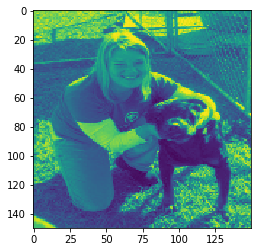

In [130]:
my_predict(3747)